Dataset shape: (1797, 64), #classes: 10


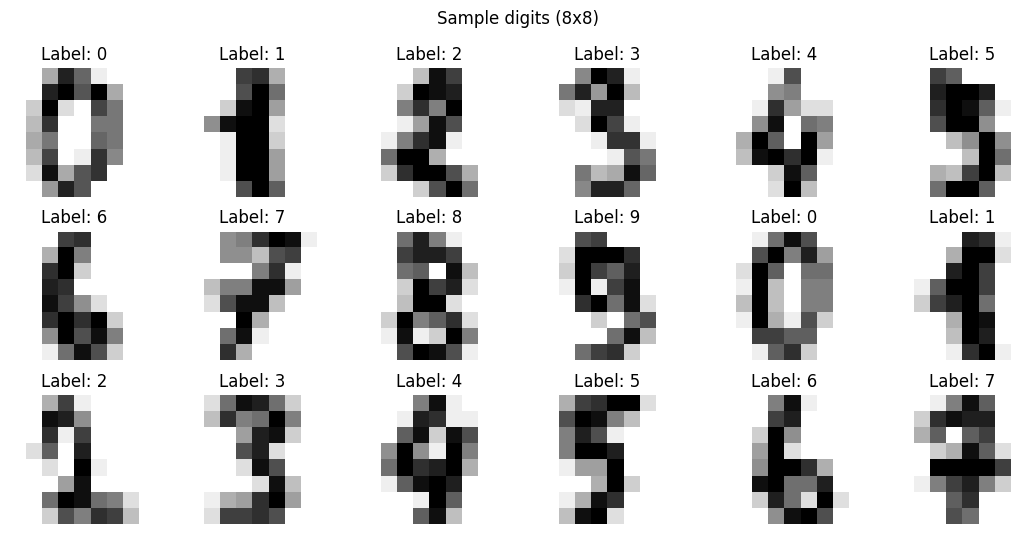

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV accuracy: 0.981911
Best params: {'pca': 'passthrough', 'svc__C': 2, 'svc__gamma': 'scale'}
Test accuracy: 0.977778

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        36
           1     0.9459    0.9722    0.9589        36
           2     1.0000    1.0000    1.0000        35
           3     1.0000    1.0000    1.0000        37
           4     0.9459    0.9722    0.9589        36
           5     0.9737    1.0000    0.9867        37
           6     0.9730    1.0000    0.9863        36
           7     0.9459    0.9722    0.9589        36
           8     1.0000    0.9143    0.9552        35
           9     1.0000    0.9444    0.9714        36

    accuracy                         0.9778       360
   macro avg     0.9784    0.9775    0.9776       360
weighted avg     0.9784    0.9778    0.9777       360



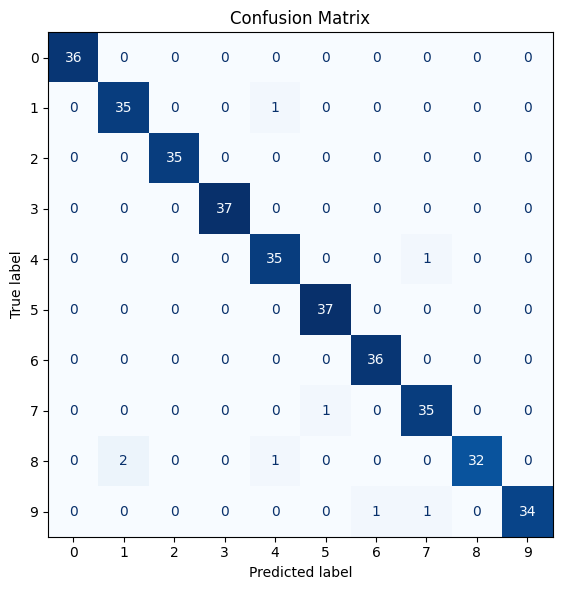

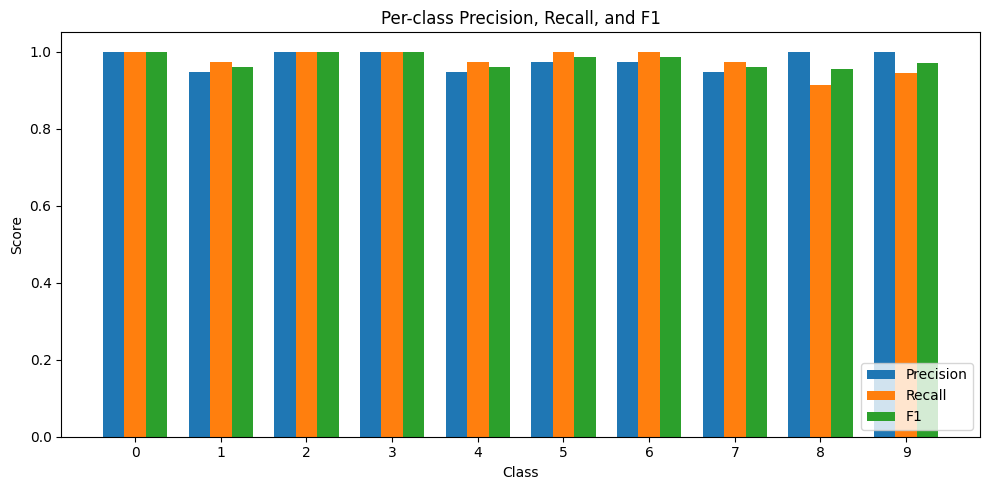

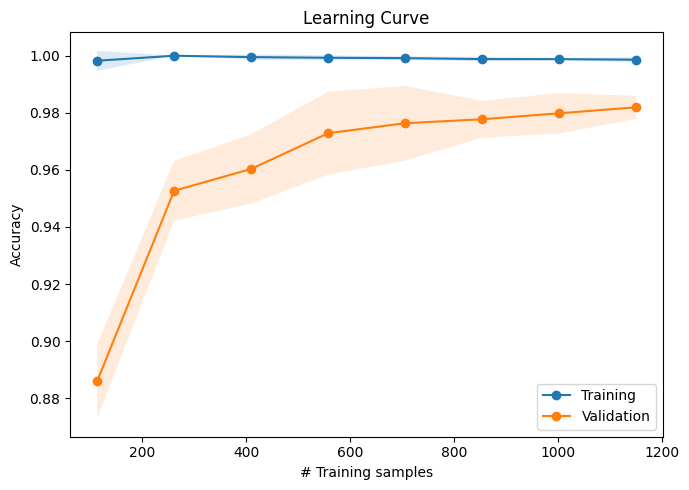

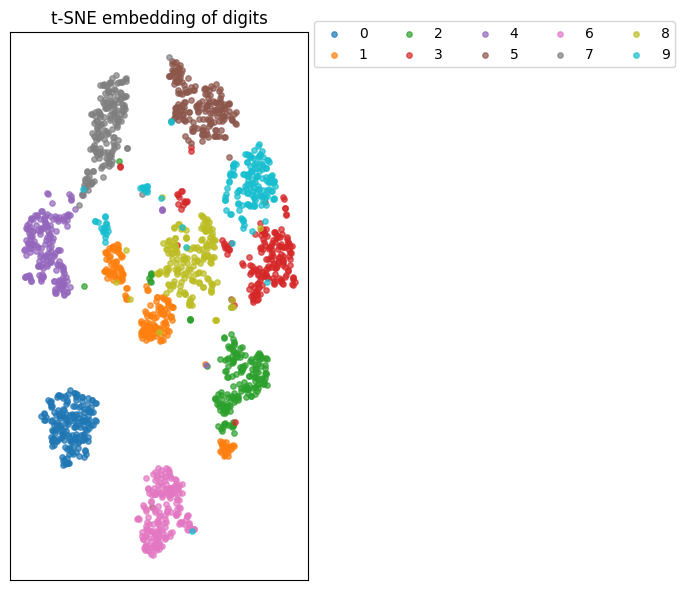

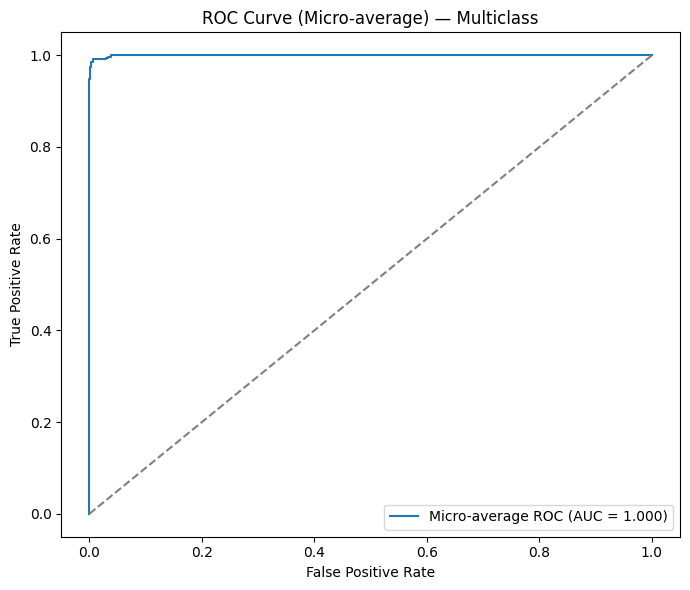

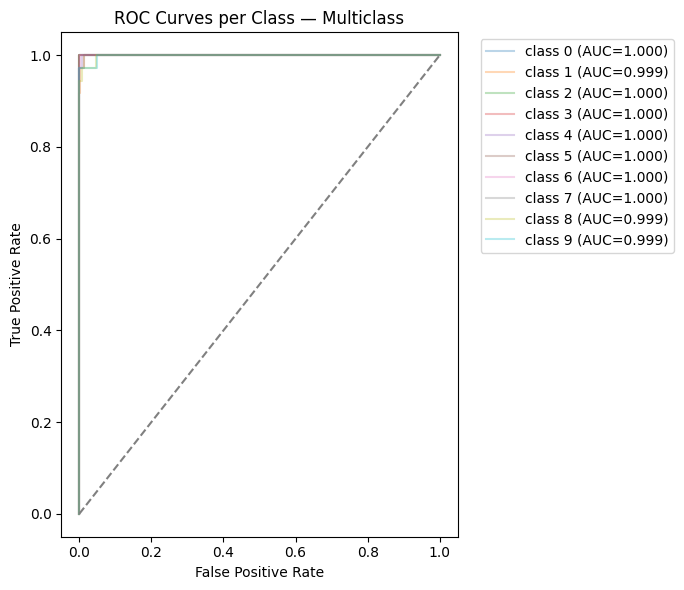

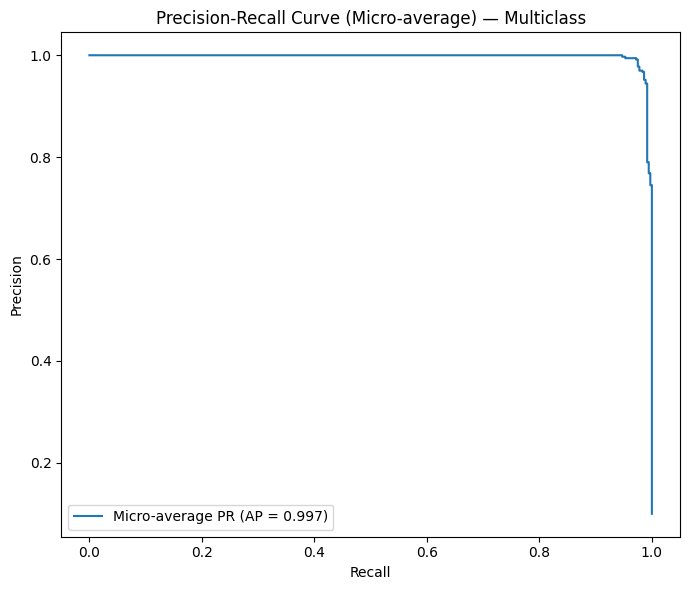

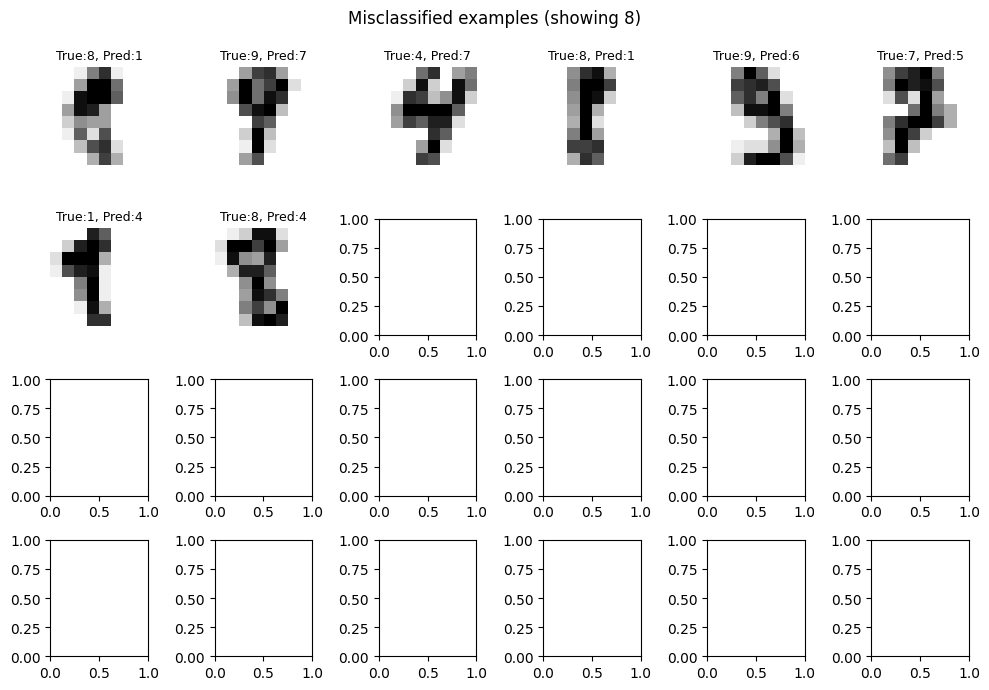

In [1]:
# ============================================================
# MNIST Digits (sklearn) — High-Accuracy Multiclass Classifier
# Best practices: clean pipeline, tuning, and rich visualizations
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
)

from sklearn.manifold import TSNE

# -------------------------
# 1) Load data
# -------------------------
digits = load_digits()
X, y = digits.data, digits.target
classes = np.unique(y)
n_classes = len(classes)
print(f"Dataset shape: {X.shape}, #classes: {n_classes}")

# Quick look at a few samples
def plot_samples(X_images, y_labels, nrows=3, ncols=6, title="Sample digits"):
    fig, axes = plt.subplots(nrows, ncols, figsize=(1.8*ncols, 1.8*nrows))
    fig.suptitle(title)
    idx = 0
    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            ax.imshow(X_images[idx], cmap="gray_r")
            ax.set_title(f"Label: {y_labels[idx]}")
            ax.axis("off")
            idx += 1
    plt.tight_layout()
    plt.show()

plot_samples(digits.images, y, nrows=3, ncols=6, title="Sample digits (8x8)")

# -------------------------
# 2) Train / Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# -------------------------
# 3) Build pipeline + grid
#    StandardScaler → (optional) PCA → SVC(RBF, probability=True)
# -------------------------
base_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("pca", "passthrough"),      # will toggle between PCA and passthrough via the grid
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

# Two parameter blocks: with & without PCA (whitened), both tuned for C & gamma
param_grid = [
    {
        "pca": ["passthrough"],
        "svc__C":    [1, 2, 4, 8, 16, 32],
        "svc__gamma": ["scale", 0.01, 0.02, 0.05, 0.1]
    },
    {
        "pca": [PCA(n_components=0.95, whiten=True, random_state=42)],
        "svc__C":    [1, 2, 4, 8, 16, 32],
        "svc__gamma": ["scale", 0.01, 0.02, 0.05, 0.1]
    },
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

search.fit(X_train, y_train)

print(f"Best CV accuracy: {search.best_score_:.6f}")
print(f"Best params: {search.best_params_}")

best_model = search.best_estimator_

# -------------------------
# 4) Final evaluation on held-out test
# -------------------------
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.6f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# -------------------------
# 5) Visualizations
# -------------------------

# 5.1 Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)
fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 5.2 Per-class Precision/Recall/F1 (bar chart)
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=classes, zero_division=0)
x = np.arange(n_classes)
width = 0.25
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, prec, width, label="Precision")
ax.bar(x,        rec,  width, label="Recall")
ax.bar(x + width, f1,  width, label="F1")
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_xlabel("Class")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Per-class Precision, Recall, and F1")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 5.3 Learning Curve (sanity check for bias/variance & sample efficiency)
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=cv, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1, shuffle=True, random_state=42
)
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training")
ax.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation")
ax.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.15)
ax.fill_between(train_sizes, val_scores.mean(axis=1) - val_scores.std(axis=1),
                val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.15)
ax.set_xlabel("# Training samples")
ax.set_ylabel("Accuracy")
ax.set_title("Learning Curve")
ax.legend()
plt.tight_layout()
plt.show()

# 5.4 PCA cumulative explained variance (only if PCA was selected)
if isinstance(best_model.named_steps["pca"], PCA):
    # Refit PCA on full training set to inspect explained variance
    pca = best_model.named_steps["pca"]
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(np.arange(1, len(cum_var)+1), cum_var, marker="o")
    ax.set_xlabel("# Components")
    ax.set_ylabel("Cumulative explained variance")
    ax.set_title("PCA Cumulative Explained Variance")
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

# 5.5 t-SNE 2D embedding (visualize separability)
#     Use a light preprocessing for visualization only (scale + optional PCA to 30 dims for t-SNE speed)
scaler_vis = StandardScaler()
X_scaled_vis = scaler_vis.fit_transform(X)
pca_vis = PCA(n_components=min(30, X.shape[1]), random_state=42).fit_transform(X_scaled_vis)
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(pca_vis)

fig, ax = plt.subplots(figsize=(7, 6))
for digit in classes:
    idx = np.where(y == digit)[0]
    ax.scatter(X_tsne[idx, 0], X_tsne[idx, 1], s=15, alpha=0.7, label=str(digit))
ax.set_title("t-SNE embedding of digits")
ax.set_xticks([])
ax.set_yticks([])
ax.legend(ncol=5, bbox_to_anchor=(1.02, 1.02), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()

# 5.6 Multiclass ROC (micro & macro) + AUC
#     For multiclass, compute micro/macro average using one-vs-rest probabilities
y_test_bin = label_binarize(y_test, classes=classes)
y_proba = best_model.predict_proba(X_test)  # shape: [n_samples, n_classes]

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
auc_micro = roc_auc_score(y_test_bin, y_proba, average="micro", multi_class="ovr")

# Macro-average
# Compute per-class ROC, then average TPR interpolated across all classes
fpr_dict, tpr_dict, auc_dict = {}, {}, {}
for i, c in enumerate(classes):
    fpr_dict[c], tpr_dict[c], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc_dict[c] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])

# Plot micro and macro (macro as mean of per-class AUCs)
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {auc_micro:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (Micro-average) — Multiclass")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 6))
for c in classes:
    ax.plot(fpr_dict[c], tpr_dict[c], alpha=0.3, label=f"class {c} (AUC={auc_dict[c]:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves per Class — Multiclass")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 5.7 Multiclass PR (micro) + AP
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
ap_micro = average_precision_score(y_test_bin, y_proba, average="micro")

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(recall_micro, precision_micro, label=f"Micro-average PR (AP = {ap_micro:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve (Micro-average) — Multiclass")
ax.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 6) Inspect misclassifications
# -------------------------
mis_idx = np.where(y_pred != y_test)[0]
if len(mis_idx) > 0:
    n_show = min(24, len(mis_idx))
    fig, axes = plt.subplots(4, 6, figsize=(10, 7))
    fig.suptitle(f"Misclassified examples (showing {n_show})")
    for k, ax in enumerate(axes.ravel()[:n_show]):
        i = mis_idx[k]
        ax.imshow(digits.images[train_test_split(range(len(y)), test_size=0.20, stratify=y, random_state=42)[1]][i], cmap="gray_r")
        ax.axis("off")
        ax.set_title(f"True:{y_test[i]}, Pred:{y_pred[i]}", fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications — perfect test score (rare but possible).")
